# 2.D. Cleaning and Engineering -- Audio Files

Recall that part of our Spotify pull included **30 second song snippets** via preview_urls. In this section of our project, we'll take the time to iterate through each of these song snippets and extract a number of custom audio features, separate from those provided via the Spotify API. Again, while the latter are more reliable measures for audio classification, we are doing this to get some additional exposure into **librosa**, a popular library for audio feature engineering/extraction.

Our workflow will be:
 1. Grab all of our preview_urls
 2. Save song snippets
 3. For each song, extract key audio features, and save our mel-spectograms

**NOTE: The below code was run locally to extract song files to an external hard drive. Once gathered, they were archived and pushed to AWS. From there, amended versions of the librosa code were executed in our AWS environment (some of the librosa methods take an extremely long time to run). Once completed, WinSCP was leveraged to retrieve our .csv and store it locally for manipulation/concatenation with other dataframes**

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import time
import urllib
import urllib.request
import requests
from urllib import request
import ffmpeg
import sys
import os
import sys
import librosa
import librosa.display as display
import IPython.display as ipd
from tqdm import tqdm

## Save our .mp3 files

In [2]:
#Grab our data
df_for_mp3s = pd.read_csv('cleaned_with_sentiment_needs_review.csv')

In [73]:
df_for_mp3s.shape

(25130, 58)

In [74]:
df_for_mp3s.columns

Index(['album', 'artist', 'date', 'features', 'lyrics', 'producers', 'song',
       'artist_clean', 'album_name_clean', 'track_clean', 'acousticness',
       'album_id', 'album_name', 'artist_id', 'danceability', 'duration_ms',
       'energy', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'preview_url', 'speechiness', 'tempo', 'time_signature',
       'track_href', 'track_id', 'track_name', 'uri', 'valence', 'genres',
       'pop', 'follower', 'cleaned_lyrics', 'split_lyrics', 'number_lines',
       'track_unique_words_pct', 'track_unique_words', 'track_complexity',
       'track_total_words', 'artist_vocab_size', 'artist_vocab_complexity',
       'track_rhyme_density', 'cleaned_lyrics_for_sentiment',
       'sentiment_track_neg', 'sentiment_track_pos', 'sentiment_track_neu',
       'sentiment_track_comp', 'track_sad_words', 'track_angry_words',
       'track_joy_words', 'track_ant_words', 'track_trust_words',
       'track_fear_words', 'track_disgust_words',

In [3]:
#Isolate down to the features that we care about for saving our mp3s -- notably, track id, track name, etc.
df_for_grabbing_and_saving = df_for_mp3s[['artist_clean', 'artist_id', 'album_name', 'album_id', 'track_id', 'track_clean', 'preview_url']]

In [47]:
#For every track (row), grab our ids and retrieve our son snippet. Save to external hard drive
#with concat'ed ID information

for index, row in df_for_grabbing_and_saving.iterrows():
    artist_name = str(row['artist_clean'])
    album_name = str(row['album_name'])
    artist_id = str(row['artist_id'])
    album_id = str(row['album_id'])
    track_id = str(row['track_id'])
    track_clean = str(row['track_clean'])
    preview_url = str(row['preview_url'])
    
    urllib.request.urlretrieve(preview_url,'D:/song_snippets/'
                        +artist_id + "_"
                        +album_id + "_" 
                        +track_id + '.mp3')

In [18]:
#Build a librosa_id field to read out files back into our dataframes
df_for_grabbing_and_saving['librosa_id'] = df_for_grabbing_and_saving['artist_id'] + "_" + df_for_grabbing_and_saving['album_id'] + "_" +  df_for_grabbing_and_saving['track_id']
df_for_mp3s['librosa_id'] = df_for_mp3s['artist_id'] + "_" + df_for_mp3s['album_id'] + "_" +  df_for_mp3s['track_id']

C:\Users\Owen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [4]:
import audioread, ffmpeg

## Extract Audio Features from MP3

In [5]:
# We're going to be reading in a number of audio features from librosa back into our dataframe
# We'll set these columns to zero and fill in as we iterate through
df_for_grabbing_and_saving['onset_env'] = 0
df_for_grabbing_and_saving['tempo'] = 0
df_for_grabbing_and_saving['chroma_stft'] = 0
df_for_grabbing_and_saving['spec_cent'] = 0
df_for_grabbing_and_saving['spec_bw'] = 0
df_for_grabbing_and_saving['rolloff'] = 0
df_for_grabbing_and_saving['zcr'] = 0
df_for_grabbing_and_saving['mfcc'] = 0

C:\Users\Owen\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Owen\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Owen\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [6]:
librosa_id = []
tempo= []
chroma_stft = []
spec_cent =[]
spec_bw = []
rolloff = []
zcr = []
mfcc = []

#Point to directory with song snippets
directory = 'D:/song_snippets'

#instantiate empty dict
mels = {}

#for all the files in our folder, pass them into librosa and extract key audio features
for filename in os.listdir(directory):

    librosa_id.append(filename)
    
    try:
        y,sr  = librosa.load(directory + '/' + filename)
    except:
        pass
    
    
    try:
        tempo.append(np.mean(librosa.beat.tempo(onset_envelope=onset_env, sr=sr))) 
    except:
        tempo.append(0) 
    try:   
        chroma_stft.append(np.mean(librosa.feature.chroma_stft(y=y, sr=sr)))  
    except:
        chroma_stft.append(0)
    try:   
        spec_cent.append(np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))) 
    except:
        spec_cent.append(0) 
    try:           
        spec_bw.append(np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)))
    except:
        spec_bw.append(0)
    try:           
        rolloff.append(np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)))
    except:
        rolloff.append(0)
    try:           
        zcr.append(np.mean(librosa.feature.zero_crossing_rate(y)))
    except:
        zcr.append(0)  
    try:           
        mfcc.append(np.mean(librosa.feature.mfcc(y=y, sr=sr)))
    except:
        mfcc.append(0)
    try: 
        #store our spectograms in a spearate dictionary for reference
        spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=2048, hop_length=512)
        spect = librosa.power_to_db(spect, ref=np.max)
        mels[filename] = spect
    except:
        mels[filename] = ''


C:\Users\Owen\Anaconda3\lib\site-packages\librosa\core\audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
C:\Users\Owen\Anaconda3\lib\site-packages\librosa\core\audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
C:\Users\Owen\Anaconda3\lib\site-packages\librosa\core\pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


In [24]:
mels['00fUxTsDQ3TMlro9Abk6bG_4TJvw1m1Nr73bDYdkv3AqL_3cVV8YvToApBe3BHENWd30.mp3'].shape

(128, 1292)

In [12]:
temp_audio_features_df = pd.DataFrame(zip(librosa_id, tempo, chroma_stft, spec_cent, spec_bw, rolloff, zcr, mfcc))
temp_audio_features_df.columns = ['librosa_id', 'tempo', 'chroma_stft', 'spec_cent', 'spec_bw', 'rolloff', 'zcr', 'mfcc']

In [55]:
temp_audio_features_df.librosa_id = temp_audio_features_df.librosa_id.str.replace('.mp3','')

In [57]:
combined_df = pd.merge(df_for_mp3s,temp_audio_features_df, on='librosa_id', how='left')

In [58]:
combined_df.to_csv('cleaned_lyrics_and_audio_features.csv', index=False)

In [34]:
import hickle as hk
hk.dump(mels,'D:/mels.hkl')

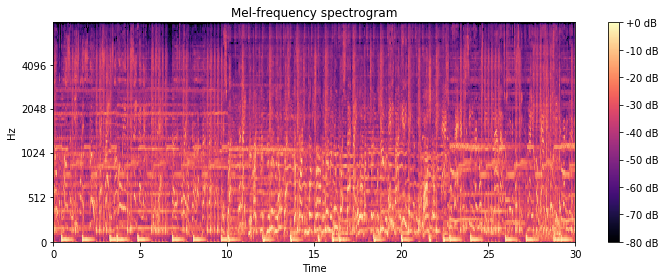

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
librosa.display.specshow(spect, x_axis='time',
                            y_axis='mel', sr=sr,
                           fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()